![logo](../img/LogoLine_horizon_C3S.png)

# The Total Solar Irradiance (TSI) from RMIB

This notebook provides a practical introduction to the 
[C3S Earth's radiation budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-earth-radiation-budget?tab=overview)
dataset.
We give a short introduction to the ECV Earth Radiation Budget, ECV Product Total Solar Irradiance (TSI), and present two use cases of the dataset: plot the TSI daily values and a 12-month rolling mean, and plot two TSI composite datasets side-by-sides.

The notebook has two main sections with the following outline:


## Table of Contents

* Introduction
* Download Data Using CDS API
* Use case 1: Time series of the Total Solar Irradiance (TSI)
* Use case 2: Comparison of two TSI composites
* References


### How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=C3S_TSI.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/C3S_TSI.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/C3S_TSI.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need. You will also need to install [Pandas](https://pandas.pydata.org/) for data manipulation and analysis, and the CDS API (`pip install cdsapi`) for downloading data programatically from the CDS. 

##  Introduction

<br>
<div style="text-align: justify"> The Total Solar Irradiance (TSI) is one of the Global Climate Observing System (GCOS) Essential Climate Variables (ECV), and it is a key component of the Earth’s Radiation Budget (ERB). 99,96% of the incoming energy is the radiant energy of the Sun and it's monitored from space by instruments measureing the TSI. Fortunately, the TSI is very stable in the long timescales (thus historical name of TSI as "the solar constant"), although shorter-term solar variations are clearly detectable. The well-known 11-year solar -cycle is also being directly observed by space-based intruments, with variation of ~0.1% max to min. TSI is the spectrally integrated total amount of radiant energy coming from the Sun per square meter of surface perpendicular to the sunlight reduced at a distance of one Astronomical Unit (AU). Stable long-term TSI records re needed to understand the influence of solar variability on climate.</div>

<div style="text-align: justify">Within the Copernicus Climate Change Service (C3S), a long composite TSI Climate Data Record (CDR) is constructed from different TSI measurements obtained by an ensemble of space instruments. In order to create the composite, the measurements of the individual instruments are first put on a common absolute scale, and their quality is assessed by intercomparison. Then, the composite time series is the average of all available measurements, on a daily basis.<br>  
This dataset is produced on behalf of C3S by the Royal Meteorological Institute of Belgium (RMIB). It provides daily means of the TSI from January 1979 to present. </div>  

Please find further information about the dataset as well as the data in the Climate Data Store catalogue entry Earth's Radiation Budget, sections "Overview", "Download data" and "Documentation": 
- [Earth's Radiation Budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-earth-radiation-budget?tab=overview)

### Import libraries

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case, we will use Matplotlib and Cartopy.

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it: <br>
```!pip install cdsapi```

In [1]:
# CDS API library
import cdsapi

# Library for data manipulation and analysis
import pandas as pd

# Libraries to work with zip-archives, pattern expansion
import zipfile
import glob

# Library for plotting and visualising data
import matplotlib.pyplot as plt

##  Download data using CDS API

### Set up CDS API credentials

<div style="text-align: justify"> We will request data from the Climate Data Store (CDS): https://cds.climate.copernicus.eu/cdsapp#!/home. In case you don't have an account yet, please click on "Login/register" at the right top and select "Create new account". With the process finished you are able to login to the CDS and can search for your preferred data.</div>

We will request data from the CDS programmatically with the help of the CDS API. 
First, we need to manually set the CDS API credentials. 
To do so, we need to define two variables: URL and KEY. 
To obtain these, first login to the CDS, then visit https://cds.climate.copernicus.eu/api-how-to and copy) the string of characters listed after "key:". Replace the `#########` below with this string.


In [2]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '#########'

Next, we specify a data directory in which we will download our data and all output files that we will generate:

In [3]:
DATADIR = './data-dir/'

### Search for data

To search for data, visit the CDS website: https://cds.climate.copernicus.eu/cdsapp#!/home.
Here you can search for TSI data using the search bar. The data we need for this use case is the [Earth's Radiation Budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-earth-radiation-budget?tab=overview).
The Earth Radiation Budget (ERB) comprises the quantification of the incoming radiation from the Sun and the outgoing reflected shortwave and emitted longwave radiation. This catalogue entry comprises data from a number of sources.

Having selected the correct catalogue entry, we now need to specify what origin, variables, temporal and geographic coverage we are interested in. 
These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Origin: `C3S RMIB`
- Variable: `Total Solar Irradiance`
- Format: `Compressed zip file (.zip)`

If you have not already done so, you will need to accept the **terms & conditions** of the data before you can download it.

At the end of the download form, select **`Show API request`**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below) ...

In [5]:
c = cdsapi.Client() # url=URL, key=KEY)

c.retrieve(
    'satellite-earth-radiation-budget',
    {
        'origin': 'c3s_rmib',
        'variable': 'total_solar_irradiance',
        'format': 'zip',
    },
    f'{DATADIR}TSI_data.zip')


2023-11-03 17:22:48,751 INFO Welcome to the CDS
2023-11-03 17:22:48,752 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-earth-radiation-budget
2023-11-03 17:22:49,039 INFO Request is queued
2023-11-03 17:22:50,084 INFO Request is running
2023-11-03 17:22:51,632 INFO Request is completed
2023-11-03 17:22:51,633 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data9/dataset-satellite-earth-radiation-budget-f86ab00c-e28a-49ad-bf33-fde8cd756c7e.zip to ./TSI_data.zip (556.8K)
2023-11-03 17:22:52,000 INFO Download rate 1.5M/s 


Result(content_length=570185,content_type=application/zip,location=https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data9/dataset-satellite-earth-radiation-budget-f86ab00c-e28a-49ad-bf33-fde8cd756c7e.zip)

### Unpack the data

We use zipfile module to extract the content of the archive we just downloaded. The file is extracted into the specified directory path, represented by the `DATADIR` variable.

In [6]:
with zipfile.ZipFile(f'{DATADIR}TSI_data.zip', 'r') as zip_ref:
    zip_ref.extractall(f'{DATADIR}')

##  Use case 1: Time series of the Total Solar Irradiance (TSI)

<br>
In this learning material, we visualize the time evolution of the Total Solar Irradiance (TSI) using daily values and a 12-month rolling mean. This visualization helps us understand the variations in TSI over time.

### Load dataset, subselect and calculate temporal mean

<div style="text-align: justify"> First, we need to read the file and prepare the dataset for analysis and plotting.<br>  
The TSI data is stored in ASCII file. We use Pandas to read the file. TSI dataset is constantly updated, that is why we need to use glob to get the latest filename.<br>
We read a dataset file specified by the filename variable using pandas `pd.read_csv()` into DataFrame. The file has a header with 67 lines of metadata that is skipped during the reading process. We extracts columns 1 and 2 (zero-based indexing) from the CSV file, naming them as "TSI" and "JD" respectively, and set the "JD" column as the DataFrame's index. The "JD" column contains Julian date values representing time.<br>
As the next we convert these Julian date values to a datetime format using `pd.to_datetime()` and set units as Date.
Finally, we use lambda-function to set time to midnight (00:00:00) for each date, effectively discarding the time information, and leaving only the date component in the index.</div>

In [7]:
filename = glob.glob(f'{DATADIR}C3S_RMIB_daily_TSI_composite_*.txt')[0]

# read the file
data = pd.read_csv(
    filename, header=67, sep=' ', usecols=[1, 2], names=["TSI", "JD"], index_col=1, encoding= 'unicode_escape'
)
# convert julian date values to a datetime format
data.index = pd.to_datetime(data.index, origin='julian', unit='D')
# set time to midnight using lambda-function
data.index = data.index.map(lambda x: x.replace(hour=0, minute=0, second=0))

### Print header information to learn about the dataset

The header contain general information about the dataset, satellite instruments used to create a composite dataset, and columns are explained. Peer-reviewed by Dewitte et al (2016) describes the dataset.

In [8]:
# read the dataset metadata from the header
with open(filename, 'r') as file:
    header_lines = [next(file) for _ in range(67)]

# print the information
print("".join(header_lines))

# C3S daily Total Solar Irradiance (TSI) timeseries
# 
# The TSI is the total amount of solar radiation, i.e. integrated over the all wavelength, at the mean  
# Earth-Sun distance (1 AU). Given its direct impact on the Earth Radiation Budget (ERB), it is one of  
# the Essential Climate Variables (ECV) defined by the GCOS. 
# 
# This C3S timeseries provides an estimate of the daily TSI computed as a composite of different
# space instruments (see list after). 
# 
# CDR type : ICDR
# CDR version : v2.5
# 
# CDR provider : Royal Meteorological Institute of Belgium
# Contract : C3S_312b_lot1                                
# 
# Temporal resolution : daily
# Covered period start (YYYYMMDD) : 19790101
# Covered period end   (YYYYMMDD) : 20220630
# 
# Creation date and time (YYYYMMDD_hhmmss) : 20220926_130838
# Software version                         : v2.1
# 
# Instruments and adjustment factors:
#     0 : "ERB"                                        0.993204
#     1 : "ACRIM1"           

### Plot data

We want to save objects `figure` and `axes` to use later. We use [Matplotlib](https://matplotlib.org/stable/index.html) to create a high-quality plot. Before plotting we need to prepare daily values, and 12-month rolling mean.<br>   


<div style="text-align: justify">The rolling mean is a statistical technique used to smooth out data by calculating the average of a specified window of values. In our case, the window is 365-days or 12-month.  
By applying the rolling mean to the TSI dataset spanning from 1979 to 2023, we can clearly observe the presence of three distinct solar cycles. These cycles represent periods of varying solar activity and are characterized by the rise and fall of sunspot numbers and other solar phenomena. Solar cycle 22, spanning from 1986 to 1996, is followed by solar cycle 23, which occurred from 1996 to 2008. Finally, solar cycle 24 took place from 2008 to 2019. These solar cycles demonstrate the cyclic nature of solar activity and its influence on the TSI measurements.</div>

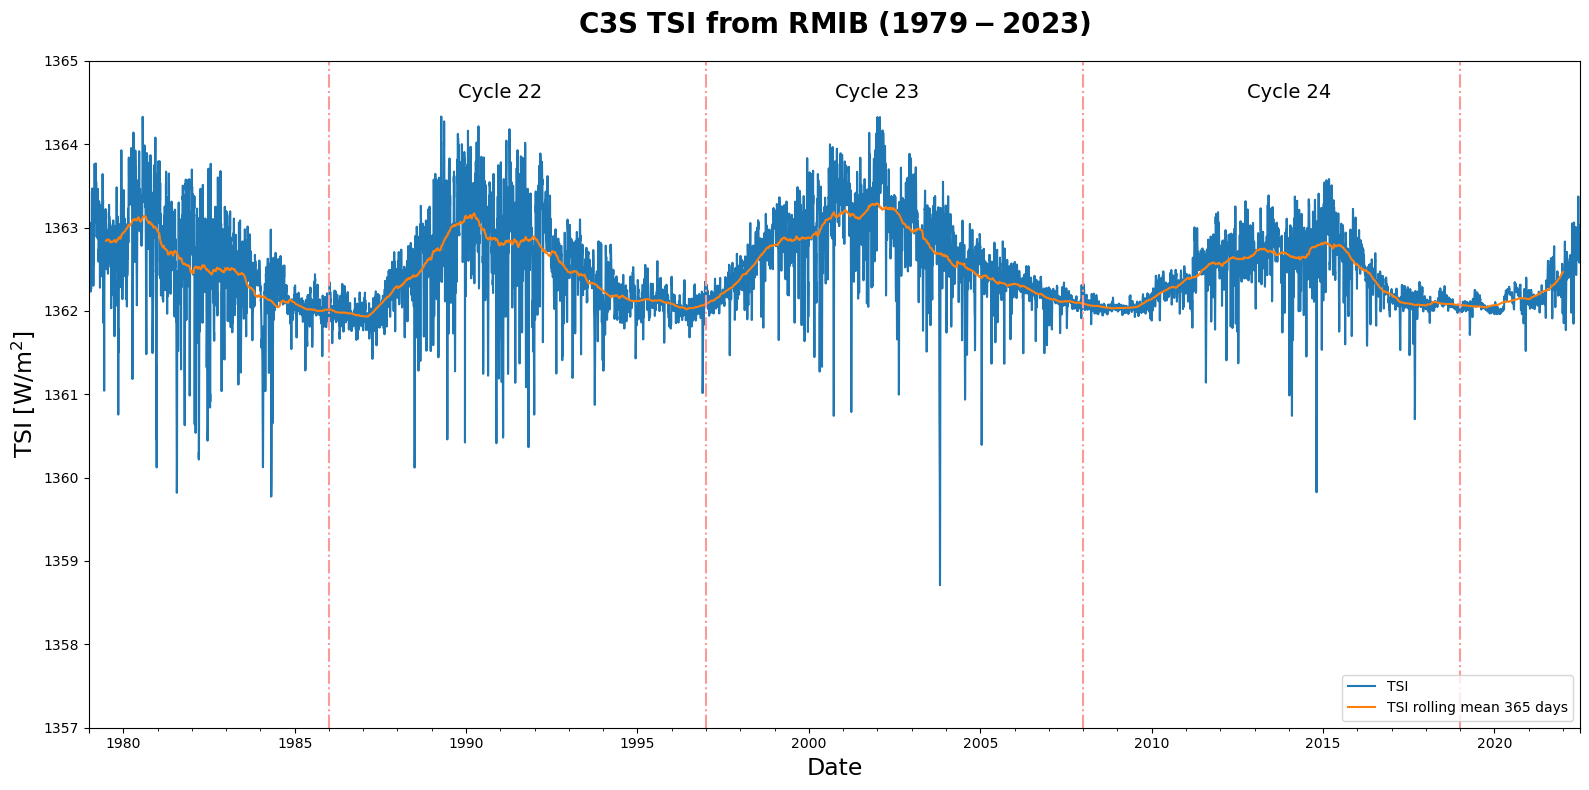

In [9]:
# Save figure and axes objects to modify later
fig1, ax1 = plt.subplots(1, 1, figsize=[16, 8])

# Actual plotting of the data
data.TSI.rolling(window=1).mean().plot()
data.TSI.rolling(window=365, center=True).mean().plot(legend=True)

# Adding title, x,y labels, and legend at lower right corner
ax1.set_ylim(1357, 1365)
ax1.set_title('$\\bf{C3S\ TSI\ from\ RMIB\ (1979-2023)}$',fontsize=20, pad = 20)
ax1.set_ylabel('TSI [W/m$^2$]', fontsize=17)
ax1.set_xlabel('Date', fontsize=17)
ax1.legend(["TSI", "TSI rolling mean 365 days"], loc="lower right");

# Adding vertical lines and labels to distinguish solar cycles
ax1.axvline(pd.to_datetime('1986-01-01'), color="#fb9a99", linestyle="-.")
ax1.axvline(pd.to_datetime('1997-01-01'), color="#fb9a99", linestyle="-.")
ax1.axvline(pd.to_datetime('2008-01-01'), color="#fb9a99", linestyle="-.")
ax1.axvline(pd.to_datetime('2019-01-01'), color="#fb9a99", linestyle="-.")
ax1.text(pd.to_datetime('1991-01-01'), 1364.5, "Cycle 22", ha="center", va="bottom", color="k", fontsize=14)
ax1.text(pd.to_datetime('2002-01-01'), 1364.5, "Cycle 23", ha="center", va="bottom", color="k", fontsize=14)
ax1.text(pd.to_datetime('2014-01-01'), 1364.5, "Cycle 24", ha="center", va="bottom", color="k", fontsize=14)

plt.tight_layout()
plt.show()

# and save the figure
fig1.savefig('Example_1_TSI_timeseries.png', dpi=300, bbox_inches='tight')

## Use case 2: Side-by-side composite products


The existing 44+ year TSI Climate Data Record (CDR) is the result of several overlapping TSI instruments onboard different satellites. Another well-known composite TSI data are produced by the Naval Research Laboratory (NRL). Each organization collects TSI measurements from various satellite instruments and combines them to create a composite dataset that represents the overall TSI variations over time. In this usecase we will plot these two composite datasets side-by-side.

### Download NRL dataset, subselecting the time range

The NRL TSI dataset is made available through LaTiS, which is a data serving system. It offers multiple methods to access the dataset, providing users with different options to retrieve the data according to their needs or preferences. We then download the selected parameters using `wget`.

* `nrl2_tsi_P1D.csv`: TSI daily dataset name on the LaTiS server;
* `?time,irradiance`: These are the variables that are requested from the dataset: time and irradiance;
* `&formatTime(yyyyMMdd)`: This is a LaTiS function that formats the time variable as a date string in the format yyyyMMdd.
* `&time>=1979-01-01T00:00`: This is another LaTiS function that specifies that you only want data points that have a time value greater than or equal to 1979-01-01T00:00

In [10]:
# download the dataset using wget. -O specifies the output filename; -q quiet mode, to disable wget's output
!wget -O nrl.csv -q "https://lasp.colorado.edu/lisird/latis/dap/nrl2_tsi_P1D.csv?time,irradiance&formatTime(yyyyMMdd)&time>=1979-01-01T00:00"  

### Load dataset, subselect and calculate temporal mean

If you run the Use case 1, C3S RMIB dataset is already saved in the memory. If not, please run the Use case 1 first.<br>  
The TSI data is stored in ASCII file.
We read a dataset using pandas `pd.read_csv()` into DataFrame. We skip the first line, as it is the name of the columns. We also convert date values to a datetime format using `pd.to_datetime()`.

In [11]:
filename_nrl = "nrl.csv"
# read the file
data_nrl = pd.read_csv(
    filename_nrl, header=1 ,sep=',', index_col=0, names=["Date", "TSI"], 
    parse_dates=[0], date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d')
)

/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/ipykernel_83380/1095384183.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data_nrl = pd.read_csv(


### Plot data

We use [Matplotlib](https://matplotlib.org/stable/index.html) to create a high-quality plot. We follow the same steps, as in the first use case to plot these two datasets side-by-side.

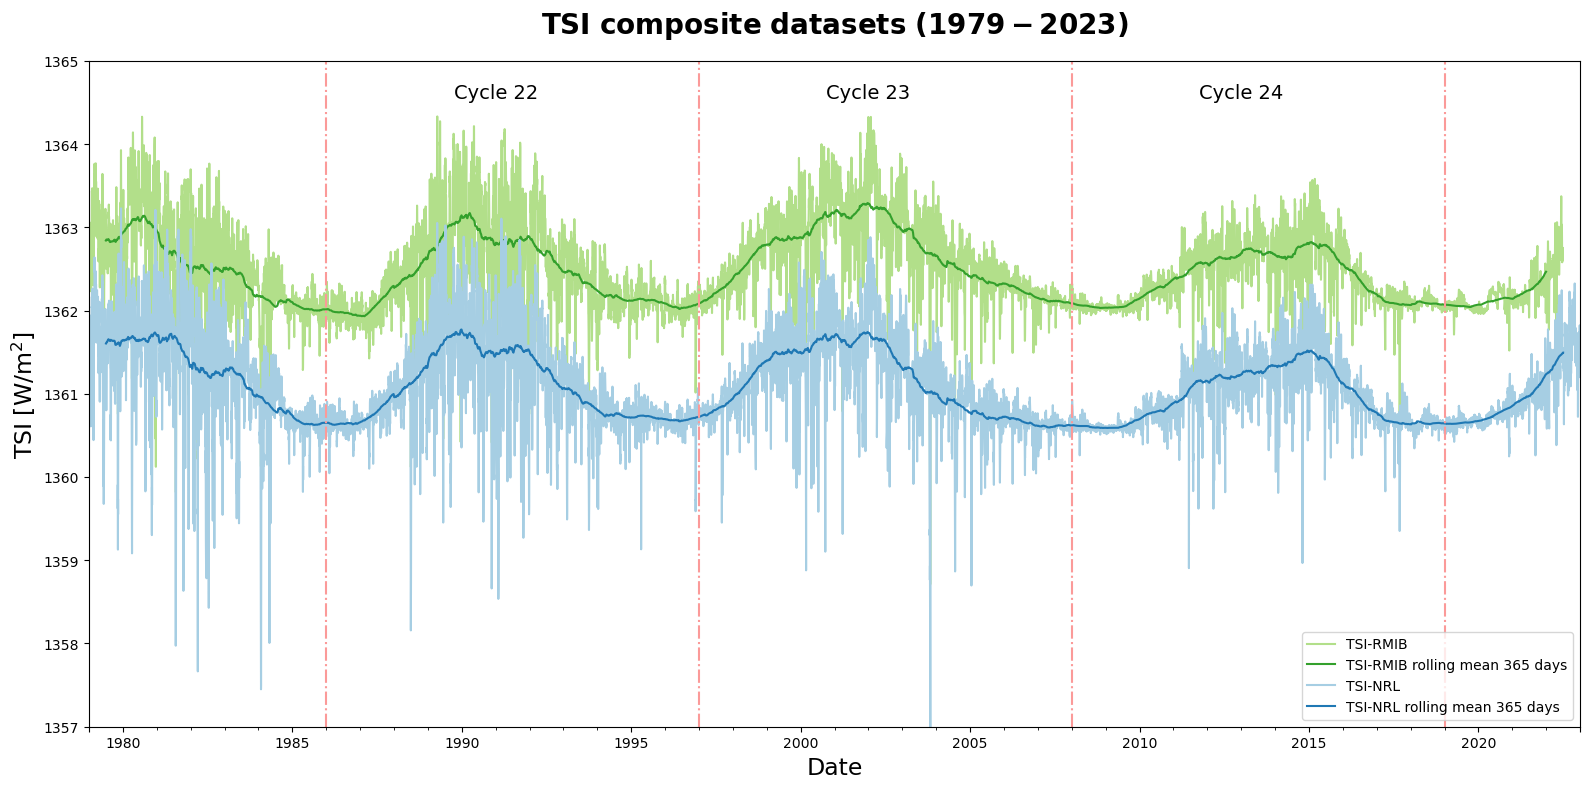

In [12]:
# Save figure and axes objects to modify later
fig2, ax2 = plt.subplots(1, 1, figsize=[16, 8])

# Actual plotting of the RMIB data
data.TSI.rolling(window=1).mean().plot(ax=ax2, color="#b2df8a")
data.TSI.rolling(window=365, center=True).mean().plot(ax=ax2, color="#33a02c")

# Actual plotting of the NRL data
data_nrl.TSI.rolling(window=1).mean().plot(ax=ax2, color="#a6cee3")
data_nrl.TSI.rolling(window=365, center=True).mean().plot(ax=ax2, color="#1f78b4")

# Adding title, x,y labels, and legend at lower right corner
ax2.set_ylim(1357,1365)
ax2.set_title('$\\bf{TSI\ composite\ datasets\ (1979-2023)}$',fontsize=20, pad = 20)
ax2.set_ylabel('TSI [W/m$^2$]',fontsize=17,)
ax2.set_xlabel('Date',fontsize=17)
ax2.legend(["TSI-RMIB", "TSI-RMIB rolling mean 365 days", "TSI-NRL", "TSI-NRL rolling mean 365 days"], loc="lower right");

# Adding vertical lines and labels to distinguish solar cycles
ax2.axvline(pd.to_datetime('1986-01-01'), color="#fb9a99", linestyle="-.")
ax2.axvline(pd.to_datetime('1997-01-01'), color="#fb9a99", linestyle="-.")
ax2.axvline(pd.to_datetime('2008-01-01'), color="#fb9a99", linestyle="-.")
ax2.axvline(pd.to_datetime('2019-01-01'), color="#fb9a99", linestyle="-.")
ax2.text(pd.to_datetime('1991-01-01'), 1364.5, "Cycle 22", ha="center", va="bottom", color="k", fontsize=14)
ax2.text(pd.to_datetime('2002-01-01'), 1364.5, "Cycle 23", ha="center", va="bottom", color="k", fontsize=14)
ax2.text(pd.to_datetime('2013-01-01'), 1364.5, "Cycle 24", ha="center", va="bottom", color="k", fontsize=14)

plt.tight_layout()
plt.show()

# and save the figure
fig2.savefig('Example_2_TSI_SideBySide.png', dpi=300, bbox_inches='tight')

## Get more information about Earth Radiation Budget:

- [About Earth's radiation budget from 1979 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-earth-radiation-budget?tab=overview)
- [About the Climate Data Store](https://cds.climate.copernicus.eu/)
- [About the Toolbox documentation](https://cds.climate.copernicus.eu/toolbox/doc/index.html)

### Acknowledgments

The results presented in this document rely on data from the Naval Research Laboratory Total Solar Irradiance 2 (NRLTSI2) model described in Coddington et al. 2016 (https://doi.org/10.1175/BAMS-D-14-00265.1). These data were accessed via the LASP Interactive Solar Irradiance Datacenter (LISIRD) (https://lasp.colorado.edu/lisird/).

##  References

Clerbaux N., (2023) Earth Radiation Budget TSI TOA. Copernicus Climate Change Service. https://confluence.ecmwf.int/x/AFMiEg

Dewitte, S., & Nevens, S. (2016). The Total Solar Irradiance Climate Data Record. The Astrophysical Journal, 830(1), 25. https://doi.org/10.3847/0004-637X/830/1/25.